In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg as sl

In [2]:
class QWZ_model_dirty_edge:
    '''
    QWZ model class
    '''
    def __init__(self, L, delta):
        '''
        Initializing the class
        '''
        
        self.L = L 
        self.d = delta
        
        self.tol = 1e-8
        
        #pauli matrices
        self.sigma_0 = np.array([[1,0],[0,1]])
        self.sigma_x = np.array([[0,1],[1,0]])
        self.sigma_y = np.array([[0,-1j],[1j,0]])
        self.sigma_z = np.array([[1,0],[0,-1]])
        
        
        self.U = delta * self.sigma_z
        self.T_x = 0.5 * (self.sigma_z + 1j*self.sigma_x)
        self.T_y = 0.5 * (self.sigma_z + 1j*self.sigma_y)
        

    def __dec(self, E, H_0,H_1):
        '''Transform the singular matrices'''
        
        U,S,V = np.linalg.svd(H_1)
        S = np.round(S,8)
        H_0_prime = U.H @ H_0 @ U
        H_1_prime = U.H @ H_1 @ U
        n = np.min(np.where(S==0))
        
        H_0_m = H_0_prime[:n,:n]
        H_0_d = H_0_prime[n:,n:]
        W = H_0_prime[:n,n:]
        K = H_1_prime[:n,:n]
        L = H_1_prime[:n,n:]

        H_0_tilde = H_0_m + W@np.linalg.inv(E*np.eye(n)-H_0_d)@W.H + L.H@np.linalg.inv(E*np.eye(n)-H_0_d)@L
        H_1_tilde = K + W@np.linalg.inv(E*np.eye(n)-H_0_d)@L

        return H_0_tilde, H_1_tilde
    
    def Green(self,E,**kwargs):
        '''
        Calculate the lead's Green's functions
            based on mezo.py
        '''
        
        self.E = E  
        H0,H1 = self.__dec(self.E, self.H0, self.H1) #reduce the singular matrices
        self.H_1=H1
        self.H1 = H1
        self.dim = np.shape(H0)[0]
           
        
        O = np.zeros_like(H0)                
        I = np.ones_like(H0)                     
        H1_inv = np.linalg.inv(H1)
        
        M_1 = np.hstack([-H1@(H0-E*I), -H1_inv@H1.H]) #eigenvalue problem
        M_2 = np.hstack([I, O])
        
        M = np.vstack([M_1,M_2])
        w,v = np.linalg.eigh(M)
        self.w = w
        
        v = np.matrix(v[:self.dim,:]) #ket phi (upper part)
        
        gv=np.zeros_like(w, dtype=complex)
        for i in range(2*self.dim):
            v[:,i] = v[:,i]/np.linalg.norm(v[:,i])  #normalized eigenstate
            gv[i] = 1.0j*((v[:,i].H*(w[i]*H1-w[i]**(-1)*H1.H)*v[:,i])[0,0]) #group velocity
            
        self.gv = gv
        
        index = np.arange(len(w))
        #-------------------------------------------opened--------------------------------------------------closed
        left = index[np.logical_or(np.logical_and(abs(abs(w)-1)<self.tol, np.real(gv)<0), np.logical_and(abs(abs(w)-1)>self.tol, abs(w)>1))]
        right = index[np.logical_or(np.logical_and(abs(abs(w)-1)<self.tol, np.real(gv)>0), np.logical_and(abs(abs(w)-1)>self.tol, abs(w)<1))]

        
        self.v_left = v[:,left]
        self.w_left  = w[left]
        self.gv_left = gv[left]
        
        self.v_right = v[:,right]
        self.w_right = w[right]
        self.gv_right =gv[right]
        
        if len(self.w_right)!=len(self.w_left):
            print('Problem with partitioning!!', len(self.w_right), len(self.w_left))
            return
        
        #calculate the dual vectors
        self.v_right_dual = np.linalg.inv(self.v_right)
        self.v_left_dual = np.linalg.inv(self.v_left)          
 
        
        left_open = np.where(abs(abs(w[left])-1 )<self.tol)[0]
        right_open = np.where(abs(abs(w[right])-1 )<self.tol)[0]             
        
        self.gv_left_open = (self.gv[left])[left_open]
        self.gv_right_open = (self.gv[right])[right_open]
        self.w_left_open = (self.w[left])[left_open]
        self.w_right_open = (self.w[right])[right_open] 
        self.left_open = left_open    
        self.v_left_open = (self.v_left[:,left_open])     
        self.v_right_open = (self.v_right[:,right_open])  
        self.v_left_dual_open = (self.v_left_dual[left_open,:])
        self.v_right_dual_open = (self.v_right_dual[right_open,:])
        
        self.T_left    = self.v_left  @ np.matrix(np.diag(1/w[left]))  @ self.v_left_dual
        self.T_right   = self.v_right @ np.matrix(np.diag(w[right]))   @ self.v_right_dual

        
        #Get Green's functions leads
        self.SG_L = self.T_left@np.linalg.inv(H1)
        self.SG_R = self.T_right@np.linalg.inv(H1.H)

    def add_scattering_hamiltonian(self, alpha, W, V_size, V_pos=None):
        '''Create the hamiltonian of a finite sample and add a scatter (as a random matrix)'''
        
        self.W = W # width of the sample
        self.s = self.L * self.W # the size
        
        #size and position of V
        try:
            self.VW = V_size[0]
            self.VL = V_size[1]
        except:
            self.VW = self.VL = V_size
            
        self.Vs = self.VW * self.VL
    
        if V_pos:
            try:
                self.Vx = V_pos[0]
                self.Vy = V_pos[1]
            except:
                self.Vx = self.Vy = pos
        else:
            self.Vx = 0
            self.Vy = np.floor((self.W-self.VW)/2)
        
            
        x_range = np.arange(self.L) 
        y_range = np.arange(self.W)
        y_coordinates, x_coordinates = np.meshgrid(y_range, x_range)
        (self.y_coordinates,self.x_coordinates) = (y_coordinates.flatten(),x_coordinates.flatten()) #coordinates to mark the place of the scattering part
        
        
        ## the hamiltonina of the sample 
        H_u = np.kron(np.eye(self.s), self.U) #onsite
        
        #hoppings
        
        h_x = np.kron(np.eye(self.W), np.eye(self.L, k=-1))
        H_x = np.matrix(np.kron(h_x, self.T_x))
        
        h_y = np.kron(np.eye(self.W, k=-1), np.eye(self.L))
        H_y = np.matrix(np.kron(h_y, self.T_y))
        
        self.H = H_u + H_x + H_x.H + H_y + H_y.H

        
        #add the scatterer
        
        self.V_x_coord = self.Vx + np.array([0,self.VL-1,self.VL-1,0,0]) #the coordinates of the scatterer
        self.V_y_coord = self.Vy + np.array([0,0,self.VW-1,self.VW-1,0])

        self.temp = matplotlib.path.Path(np.array([self.V_x_coord, self.V_y_coord]).T)
        V = matplotlib.path.Path(np.array([self.V_x_coord, self.V_y_coord]).T)        
        self.V_lattice = (V.contains_points(np.array([self.x_coordinates, self.y_coordinates]).T, radius=0.1)) #lattice sites inside the scttering part
        
        self.n_scattering_sites = np.sum(self.V_lattice) #number of sites in the scaterer
        self.V_ham = V.contains_points(np.array([np.kron(self.x_coordinates,np.ones(2)), np.kron(self.y_coordinates,np.ones(2))]).T,radius=0.1)
        self.mask = np.kron(self.V_ham.reshape((self.V_ham.size,1)), self.V_ham) #the covered part of the original matrix 

        dim = 2*self.n_scattering_sites
        R0 = np.random.randn(dim,dim)+np.random.rand(dim,dim)*1.0j 
        R0 = alpha * (R0+np.transpose(np.conjugate(R0))).flatten() # random unitary matrix
        self.R = np.zeros_like(self.H)
        self.R[self.mask] = R0 #embedding to a zero matrix
        #self.V = self.H[self.mask].reshape((2*self.n_scattering_sites, 2*self.n_scattering_sites))
        self.H_S = self.H + self.R
        

    def lattice_plot(self):
        '''function to plot the scatterer on lattice'''
        fig, ax = plt.subplots(1,1,figsize=(8,8))


        ax.plot(self.V_x_coord,self.V_y_coord, 'r-')
        ax.fill(self.V_x_coord,self.V_y_coord, color='r', alpha=0.6)
        ax.text(self.Vx-0.5+self.VL/2, self.Vy-0.5+self.VW/2, '$\hat{V}$', ha='center', va='center', fontsize=30)
        ax.plot(self.x_coordinates[np.logical_not(self.V_lattice)], self.y_coordinates[np.logical_not(self.V_lattice)], 'o')
        ax.plot(self.x_coordinates[self.V_lattice], self.y_coordinates[self.V_lattice], 'o', color='tab:red')

        ax.set_xticks(np.arange(0,self.L,1))
        ax.set_xticklabels(np.arange(0,self.L,1) + 1)
        ax.set_yticks(np.arange(0,self.W,1))
        ax.set_yticklabels(np.arange(0,self.L,1) + 1)
        ax.tick_params(size=10, direction='inout', width=2, labelsize=15)

        plt.show()
        
        
    def LDOS(self, E, alpha=0.1, delta=-1, W=10, V_size=(6,3)):
        ''''''
        self.U = delta * self.sigma_z
        
        #QWZ lead
        H_u = np.kron(np.eye(self.L), self.U)
        
        #unit cell
        h_0 = np.eye(self.L, k=1)
        H_0 = np.matrix(np.kron(h_0, self.T_x))
        self.H0 = H_u + H_0 + H_0.H
        
        #relations between unit cells
        h_1 = np.eye(self.L)
        self.H1 = np.matrix(np.kron(h_1, self.T_y)) #singular matrix...
        
        self.Green(E) #lead's Green's functions at E
        
        self.add_scattering_hamiltonian(alpha, W, V_size) # add sample with scaterer
        self.G0S = np.linalg.inv((E*np.ones_like(self.H_S))-self.H_S)# the Green's function of the scaterer 
        
        
        #decoupled Green's functions
        self.G0 = np.vstack([np.hstack([self.SG_L, np.zeros((np.shape(self.SG_L)[0], np.shape(self.G0S)[1])), np.zeros((np.shape(self.SG_L)[0],np.shape(self.SG_R)[1]))]),
                             np.hstack([np.zeros((np.shape(self.G0S)[0], np.shape(self.SG_L)[1])),self.G0S, np.zeros((np.shape(self.G0S)[0],np.shape(self.SG_R)[1]))]),
                             np.hstack([np.zeros((np.shape(self.SG_L)[0],np.shape(self.SG_L)[1])), np.zeros((np.shape(self.SG_R)[0], np.shape(self.G0S)[1])), self.SG_R])])
        
        #the size of the different components
        S_g = np.array(np.shape(self.G0))
        S_h = np.array(np.shape(self.H_1))
        
        #the cupling
        self.C = np.vstack([np.hstack([np.zeros_like(self.H_1),self.H_1,np.zeros((self.H_1.shape[0], self.G0.shape[1]-3*self.H_1.shape[1])),self.H_1]),
                            np.hstack([self.H_1.H,np.zeros((self.H_1.shape[0], self.G0.shape[1]-self.H_1.shape[1]))]),
                            np.zeros((self.G0.shape[1]-4*self.H_1.shape[1], self.G0.shape[1])),
                            np.hstack([np.zeros((self.H_1.shape[0], self.G0.shape[1]-self.H_1.shape[1])),self.H_1]),
                            np.hstack([self.H_1.H, np.zeros((self.H_1.shape[0], self.G0.shape[1]-3*self.H_1.shape[1])),self.H_1.T,np.zeros_like(self.H_1)])])
        
        #Dyson's equation
        self.G = np.linalg.inv(np.linalg.inv(self.G0)-self.C)[self.dim:-self.dim,self.dim:-self.dim]
        
        D=np.array(QWZ.G.diagonal()) #diagonal part of the Green's function
        self.dos=np.imag(D)/np.pi

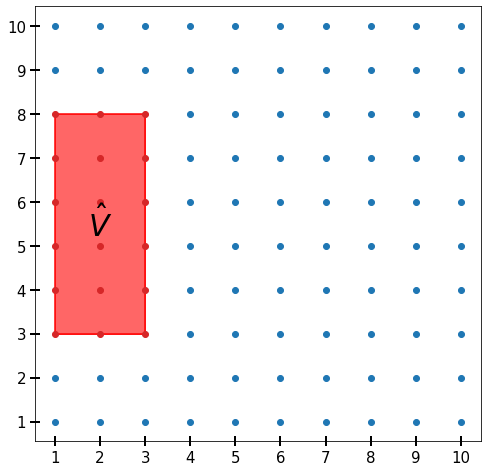

In [3]:
QWZ = QWZ_model_dirty_edge(10,-1)
QWZ.LDOS(-1)
QWZ.lattice_plot()

In [270]:
QWZ = QWZ_model_dirty_edge(10,-1)
QWZ.LDOS(0.71)